In [6]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import sys
from array import array
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from collections import defaultdict
# Insert the path of modules folder 
# sys.path.insert(0, 'C:/Users/Jason/thesis_project')
sys.path.append("../")

from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *
# import cudf

# Convert code to work with numba and cupy

In [3]:
X = genX([1994,2014], drop_0 = True)

Xbin = xBins(X, 'amd')

dropping all zero rows


### Looking at users from a specific bin 600-1200

In [4]:
list_len = []
list_ids = []

for ids in Xbin['2500-4000']:
    list_ids.append(ids)
    list_len.append(len(X.loc[ids,:]))

# Find the household that logged the most data
ix = list_len.index(max(list_len))

# Store the households ID
house_id = list_ids[ix]

# Create a dataframe with all of that households data
A = X.loc[house_id,:]
H = A.copy()

In [12]:
def find_peaksMA(X):

    df = X.copy()
    arrayX  = X.to_numpy().copy()
    arrayY = X.to_numpy().copy()

    listYM  = list(map(lambda x : x[:13],arrayY))
    listYA  = list(map(lambda x : x[12:],arrayY))

    arrayYM = np.array(listYM)
    arrayYA = np.array(listYA)

    # arrayYM.sort()
    # arrayYA.sort()

    dict_M = defaultdict(list)
    dict_A = defaultdict(list)

    df.reset_index(inplace = True)

    for i in range(0,len(arrayX)):
        indices_M = np.where(arrayYM[i] == np.amax(arrayYM[i]))
        indices_A = np.where(arrayYA[i] == np.amax(arrayYA[i]))

        dict_M[i].append(indices_M[0][0]) 
        dict_A[i].append(indices_A[0][0])

    ToP_M_df = pd.DataFrame.from_dict(dict_M)
    ToP_A_df = pd.DataFrame.from_dict(dict_A)

    top_M_dict = ToP_M_df.T
    top_A_dict = ToP_A_df.T + 12

    dict_M.clear() 
    dict_A.clear()


    X1 = df.merge(top_M_dict, left_index = True, right_index = True).merge(top_A_dict,left_index = True, right_index = True)

    return X1

# Detremine where the daily data increases and decreases after and before the peaks

### Find the average profile of a user

In [11]:
import random

list_len = []
list_ids = []

for ids in Xbin['600-1200']:
    list_ids.append(ids)
    list_len.append(len(X.loc[ids,:]))


# Gauss Fit Code

#### First load the consumption data

In [4]:
X = genX([1994,2014], drop_0 = True)

Xbin = xBins(X, 'amd')

dropping all zero rows


#### Function to determine households mean, peak times

In [5]:
# def find_peaksMA(X):    
#     # Create a copy of households mean electricity usage
#     df = X.copy()

#     arrayX = X.to_numpy().copy()

#     listYM  = list(map(lambda x : x[:13],arrayX))
#     listYA  = list(map(lambda x : x[12:],arrayX))

#     arrayYM = np.array(listYM)
#     arrayYA = np.array(listYA)

#     dict_M = defaultdict(list)
#     dict_A = defaultdict(list)

#     # Determine the time when the peaks occur
#     indices_M = np.where(arrayYM[0] == np.amax(arrayYM[0]))
#     indices_A = np.where(arrayYA[0] == np.amax(arrayYA[0]))

#     dict_M[i].append(indices_M[0][0]) 
#     dict_A[i].append(indices_A[0][0])

#     ToP_M_df = pd.DataFrame.from_dict(dict_M)
#     ToP_A_df = pd.DataFrame.from_dict(dict_A)

#     top_M_dict = ToP_M_df.T
#     top_A_dict = ToP_A_df.T + 12 # Adjust for time

#     # Reset index to insure that the three dataframes below merge properly
#     top_M_dict = top_M_dict.reset_index()
#     top_M_dict.drop(['index'], axis = 1, inplace = True)

#     top_A_dict = top_A_dict.reset_index()
#     top_A_dict.drop(['index'], axis = 1, inplace = True)
    
#     df.reset_index(inplace = True)
#     df.drop(['index'], axis = 1, inplace = True)

#     dict_M.clear() 
#     dict_A.clear()


#     X1 = df.merge(top_M_dict, left_index = True, right_index = True).merge(top_A_dict,left_index = True, right_index = True)

#     return X1

### Function to select a household

In [9]:
def selectRandomUser(Household):

    house_id = Household
    
    # Create a dataframe with all of that households data
    A = X.loc[house_id,:]
    H = A.copy()

    return H

#### Function to extract households average profile info

In [8]:
def describe_household(id):
       # Household ids
       # id = [12020322]#[483]#[2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]
       id = [id]

       for i in id:
              H = selectRandomUser(i)

              # H1 = find_peaksMA(H)
              H1_d = H.describe()

              H1_d = H1_d.drop(['count','std','min','max', '25%','50%','75%'])
              
              H1_d1 = find_peaksMA(H1_d)

       H1_d1.drop("index", axis = 1, inplace=True)
              
       return H1_d1

#### Code to create Gaussian

In [8]:
#Define the Gaussian function
def gauss(x, H, A, mu, sigma):
    return H + A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

#### Code to plot the Gaussian fit

In [9]:


def plotGaussFit(y2):
    # Household ids
    # id = [2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]

    x_all = np.arange(0, 24, 0.001) # entire range of x, both in and out of spec

    # build the plot
    fig, ax = plt.subplots(figsize=(12,6))
    plt.style.use('fivethirtyeight')  

    # Plot the households loadprofile
    fig = plt.plot(describe_household(id).iloc[0,0:24])
    plt.title("Household "+str(i))

    # Plot Gaussian fit
    ax.plot(x_all,y2)

    # Set the labels and axis limits
    ax.set_xlim([0,24])
    ax.set_xlabel('Time of day')
    ax.set_ylabel("Amplitude")
    ax.set_title('Gaussian Curve Fit')

    # # Save the figure
    # plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight')
    plt.show()

## START

#### Extract variables

In [12]:
# id = [12020322]#[483]#[2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]

#  1005558,  1006685,  1006691, 12029058, 12029066
houseID = 156

df = describe_household(id = houseID)

# Determine the y-offset i.e. minimum value in day
H_offset = df.iloc[0,:24].min()

# Determine the amplitude of gaussian
A1 = df[str(df['0_x'].values[0])].values[0] - H_offset # Adjust for offset
A2 = df[str(df['0_y'].values[0])].values[0] - H_offset

# Determine the mean of the gaussian
mu1 = df['0_x'].values[0]
mu2 = df['0_y'].values[0]

##### Get initial guesses for sigmas and Gaussians

In [13]:
def initialSigma1(increment = 0):
    

    # Conditional if statement to check that 
    p1 = 4 + increment

    i1 = 0

    Xpeak1 = df[str(df['0_x'].values[0])].values[0]

    for c in df:
        # print("c = {}, df['0_x'] = {}".format())
        if int(c) != df['0_x'].values[0]:
            x1 = df[str(df['0_x'].values[0] - int(c))].values[0]
            temp1 = Xpeak1 - x1
            # print("temp1 = Xpeak1 - x1 = {} - {} = {}".format(Xpeak1,x1,temp1))

            if temp1 >= 0.0:
                Xpeak1 = x1
            else:
                i1 = df['0_x'].values[0]-int(c)+1 # i returns the index of the lower boundary of range
                break
        else:
            i1 = df['0_x'].values[0]-int(c)+1 # i returns the index of the lower boundary of range
            break

    range1 = 2*(np.sqrt((df['0_x'].values[0] - i1)**2))

    # If statement to determine index at which to calculate error
    if range1/2 < 3:
        c1 = 1
    elif range1/2 == 3:
        c1 = 1
    elif range1/2 > 3:
        c1 = 2
    
    print("range/2 = {} thus c1 = {}".format(range1/2, c1))
    print("range/2 = {}".format(range1/2))
    sigma1 = range1/p1

    return sigma1, i1, c1


# sigma1, sigma2, i1, i2 = initialSigma1()
# y2 = gauss(x_all, H_offset,A1,mu1,initialSigma2())

In [174]:
def initialSigma3(increment = 0):
    

    # Conditional if statement to check that 
    p2 = 4 + increment

    # i1 = 0
    i2 = 0

    Xpeak2 = df[str(df['0_y'].values[0])].values[0]

    for c in df:
        x2 = df[str(df['0_y'].values[0]-int(c))].values[0]
        temp2 = Xpeak2 - x2
        
        if temp2 >= 0.0:
            Xpeak2 = x2
        else:
            i2 = df['0_y'].values[0]-int(c)+1 # i returns the index of the lower boundary of range
            break

    range2 = 2*(np.sqrt((df['0_y'].values[0] - i2)**2))

    # If statement to determine index at which to calculate error
    if range2/2 < 3:
        c1 = 1
    elif range2/2 == 3:
        c1 = 1
    elif range2/2 > 3:
        c1 = 2
    
    print("range/2 = {} thus c1 = {}".format(range2/2, c1))

    sigma2 = range2/p2

    return sigma2, i2, c1


# sigma1, sigma2, i1, i2 = initialSigma1()

In [175]:
x_all = np.arange(0, 24)

def initialSigma2(increment = 0):
    x_all = np.arange(0, 24)

    # Conditional if statement to check that 
    p1 = 4 + increment

    i1 = 0

    Xpeak1 = df[str(df['0_x'].values[0])].values[0]# Get the value at the peak
    
    for c in df:
        x1 = df[str(df['0_x'].values[0]+int(c))].values[0]
        temp1 = Xpeak1 - x1
        # print("temp1 = Xpeak1 - x1 = {} - {} = {}".format(Xpeak1,x1,temp1))
        if temp1 >= 0:
            Xpeak1 = x1
        else:
            i1 = df['0_x'].values[0]+int(c)-1 # i returns the index of the lower boundary of range
            break

    range1 = 2*(np.sqrt((df['0_x'].values[0] - i1)**2))

    # If statement to determine index at which to calculate error
    if range1/2 < 3:
        c1 = 1
    elif range1/2 == 3:
        c1 = 1
    elif range1/2 > 3:
        c1 = 2
    
    print("range/2 = {} thus c1 = {}".format(range1/2, c1))
    sigma1 = range1/p1

    return sigma1, i1, c1

# y2 = gauss(x_all, H_offset,A1,mu1,initialSigma2())

In [176]:
def initialSigma4(increment=0):
    # Conditional if statement to check that 
    p2 = 4 + increment

    i2 = 0

    Xpeak2 = df[str(df['0_y'].values[0])].values[0]# Get the value at the peak
    
    for c in df:
        try:
            x2 = df[str(df['0_y'].values[0]+int(c))].values[0] # Get the one after the peak
            temp2 = Xpeak2 - x2
            # print("temp2 = Xpeak2 - x2 = {} - {} = {}".format(Xpeak2,x2,temp2))
            
            if temp2 >= 0:
                Xpeak2 = x2
            else:
                i2 = df['0_y'].values[0]+int(c)-1 # i returns the index of the lower boundary of range
                break
            
        except KeyError:
            i2 = df['0_y'].values[0]+int(c)-1
            break

    range2 = 2*(np.sqrt((df['0_y'].values[0] - i2)**2))
    
    # If statement to determine index at which to calculate error
    if range2/2 < 3:
            c1 = 1
    elif range2/2 == 3:
        c1 = 1
    elif range2/2 > 3:
        c1 = 2
    
    print("range/2 = {} thus c1 = {}".format(range2/2, c1))

    sigma2 = range2/p2

    return sigma2, i2, c1

#### Create code that calculates the error

#### Create loop that adjusts the std deviation until error is reduced satisfactorily

##### Error code for gauss1

In [177]:
# Code that finds the value one point above the range index
sigma1, i1, c = initialSigma1()

xprofile1 = df[str(df['0_x'].values[0] - c)].values[0] # Get the amplitude values one point above the min index

xgauss = gauss(df['0_x'].values[0] - c, H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min range amplitude

error1 = xgauss - xprofile1# Calculate the error between these points

tolerance1 = 0.1
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
t = 0
while np.sqrt(error1**2) > tolerance1:
    previous_error1 = error1

    sigma1, i1, c = initialSigma1(increment = i)
    xgauss = gauss(df['0_x'].values[0] - c, H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
    error1 = xgauss - xprofile1# Calculate the error between these points

    # conditional for gauss 1
    if error1 > previous_error1:
        i = i + 0.1
        sigma1, i1, c = initialSigma1(increment = i)
        xgauss = gauss(df['0_x'].values[0] - c, H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
        error1 = xgauss - xprofile1# Calculate the error between these points
    else:
        i = i - 0.1
        sigma1, i1, c = initialSigma1(increment = i)
        xgauss = gauss(df['0_x'].values[0] - c, H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
        error1 = xgauss - xprofile1# Calculate the error between these points

    t = t + 1
    if t >= 100:
        tolerance1 = tolerance1 + 0.1

sigma1 = np.sqrt(sigma1**2)
print("sigma4 = {}".format(sigma1))
print("error1 = xgauss - xprofile1 = {} - {} = {}".format(xgauss,xprofile1,error1))

range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0
range/2 = 7.0 thus c1 = 2
range/2 = 7.0


#### Error code for gauss 3

In [178]:
# Code that finds the value one point above the range index
sigma3, i3, c = initialSigma3()

xprofile3 = df[str(df['0_y'].values[0] - c)].values[0] # Get the amplitude values one point above the min index

xgauss = gauss(df['0_y'].values[0] - c, H_offset,A2,mu2,sigma3) # Get the value of the gauss one point above the min range amplitude

error3 = xgauss - xprofile3# Calculate the error between these points

tolerance1 = 0.1
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
t = 0
while np.sqrt(error3**2) > tolerance1:
    previous_error3 = error3

    sigma3, i3, c = initialSigma3(increment = i)
    xgauss = gauss(df['0_y'].values[0] - c, H_offset,A2,mu2,sigma3) # Get the value of the gauss one point above the min peak
    error3 = xgauss - xprofile3# Calculate the error between these points

    # conditional for gauss 1
    if error3 > previous_error3:
        i = i + 0.1
        sigma3, i3, c = initialSigma3(increment = i)
        xgauss = gauss(df['0_y'].values[0] - c, H_offset,A2,mu2,sigma3) # Get the value of the gauss one point above the min peak
        error3 = xgauss - xprofile3# Calculate the error between these points
    else:
        i = i - 0.1
        sigma3, i3, c = initialSigma3(increment = i)
        xgauss = gauss(df['0_y'].values[0] - c, H_offset,A2,mu2,sigma3) # Get the value of the gauss one point above the min peak
        error3 = xgauss - xprofile3# Calculate the error between these points

    t = t + 1
    if t >= 100:
        tolerance1 = tolerance1 + 0.1

sigma3 = np.sqrt(sigma3**2)
print("sigma4 = {}".format(sigma3))
print("error1 = xgauss - xprofile3 = {} - {} = {}".format(xgauss,xprofile3,error3))

range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.0 thus c1 = 1
range/2 = 3.

#### Error code for gauss2

In [179]:
sigma2, i2, c = initialSigma2()

xprofile2 = df[str(df['0_x'].values[0] + c)].values[0] # Get the amplitude values one point below the max index

xgauss = gauss(df['0_x'].values[0] + c, H_offset,A1,mu1,sigma2) # Get the value of the gauss one point below the max index amplitude

error2 = xgauss - xprofile2# Calculate the error between these points

tolerance2 = 0.1
i = 0.5 # Constant value by which to increase/decrease the range in the initial sigma function
t = 0
while np.sqrt(error2**2) > tolerance2:
    previous_error2 = error2
    print("error2 = xgauss - xprofile2 = {} - {} = {}".format(xgauss,xprofile2,error2))
    sigma2, i2, c = initialSigma2(increment = i)
    xgauss = gauss(df['0_x'].values[0] + c, H_offset,A1,mu1,sigma2) # Get the value of the gauss one point below the max index peak
    error2 = xgauss - xprofile2# Calculate the error between these points
    
    # Conditional for gauss2
    if error2 > previous_error2:
        i = i + 0.1
        sigma2, i2, c = initialSigma2(increment = i)
        xgauss = gauss(df['0_x'].values[0] + c, H_offset,A1,mu1,sigma2) # Get the value of the gauss one point below the max index peak
        error2 = xgauss - xprofile2# Calculate the error between these points
    else:
        i = i -0.1        
        sigma2, i2, c = initialSigma2(increment = i)
        xgauss = gauss(df['0_x'].values[0] + c, H_offset,A1,mu1,sigma2) # Get the value of the gauss one point below the max peak
        error2 = xgauss - xprofile2# Calculate the error between these points

    t = t + 1
    if t >= 100:
        tolerance2 = tolerance2 + 0.1

sigma2 = np.sqrt(sigma2**2)
# print("sigma4 = {}".format(sigma2))
# print("error2 = xgauss - xprofile2 = {} - {} = {}".format(xgauss,xprofile2,error2))

range/2 = 6.0 thus c1 = 2
error2 = xgauss - xprofile2 = 36.51890437764344 - 39.40072327044025 = -2.881818892796815
range/2 = 6.0 thus c1 = 2
range/2 = 6.0 thus c1 = 2
error2 = xgauss - xprofile2 = 35.84691640968567 - 39.40072327044025 = -3.553806860754584
range/2 = 6.0 thus c1 = 2
range/2 = 6.0 thus c1 = 2
error2 = xgauss - xprofile2 = 36.01791598485062 - 39.40072327044025 = -3.382807285589635
range/2 = 6.0 thus c1 = 2
range/2 = 6.0 thus c1 = 2
error2 = xgauss - xprofile2 = 36.186991994977376 - 39.40072327044025 = -3.2137312754628766
range/2 = 6.0 thus c1 = 2
range/2 = 6.0 thus c1 = 2
error2 = xgauss - xprofile2 = 36.354027121003476 - 39.40072327044025 = -3.0466961494367766
range/2 = 6.0 thus c1 = 2
range/2 = 6.0 thus c1 = 2
error2 = xgauss - xprofile2 = 36.51890437764344 - 39.40072327044025 = -2.881818892796815
range/2 = 6.0 thus c1 = 2
range/2 = 6.0 thus c1 = 2
error2 = xgauss - xprofile2 = 36.68150724796681 - 39.40072327044025 = -2.7192160224734394
range/2 = 6.0 thus c1 = 2
range/2 

#### Error code for gauss 4

In [180]:
sigma4, i4, c = initialSigma4()

print(i4)

xprofile4 = df[str(df['0_y'].values[0] + c)].values[0] # Get the amplitude values one point below the max index

xgauss = gauss(df['0_y'].values[0] + c, H_offset,A2,mu2,sigma4) # Get the value of the gauss one point below the max index amplitude

error4 = xgauss - xprofile4# Calculate the error between these points

tolerance2 = 0.1
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
t = 0
while np.sqrt(error4**2) > tolerance2:
    previous_error4 = error4

    sigma4, i4, c = initialSigma4(increment = i)
    xgauss = gauss(df['0_y'].values[0] + c, H_offset,A2,mu2,sigma4) # Get the value of the gauss one point below the max index peak
    error4 = xgauss - xprofile4# Calculate the error between these points
    
    # Conditional for gauss2
    if error4 > previous_error4:
        i = i + 0.1
        sigma4, i4, c = initialSigma4(increment = i)
        xgauss = gauss(df['0_y'].values[0] + c, H_offset,A2,mu2,sigma4) # Get the value of the gauss one point below the max index peak
        error4 = xgauss - xprofile4# Calculate the error between these points
    else:
        i = i - 0.1        
        sigma4, i4, c = initialSigma4(increment = i)
        xgauss = gauss(df['0_y'].values[0] + c, H_offset,A2,mu2,sigma4) # Get the value of the gauss one point below the max peak
        error4 = xgauss - xprofile4# Calculate the error between these points

    t = t + 1
    if t >= 100:
        tolerance2 = tolerance2 + 0.1

sigma4 = np.sqrt(sigma4**2)
print("sigma4 = {}".format(sigma4))
print("error2 = xgauss - xprofile2 = {} - {} = {}".format(xgauss,xprofile4,error4))

range/2 = 4.0 thus c1 = 2
23
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 = 4.0 thus c1 = 2
range/2 =

#### Create function that plots all 4 gaussians

In [404]:
# sigma1, sigma3, i1, i3= initialSigma1()
# sigma2, sigma4, i2, i4 = initialSigma2()
x_all = np.arange(0, 24, 0.1) # entire range of x, both in and out of spec
y1 = gauss(x_all, H_offset,A1,mu1,sigma1)
y2 = gauss(x_all, H_offset,A1,mu1,sigma2)
y3 = gauss(x_all, H_offset,A2,mu2,sigma3)
y4 = gauss(x_all, H_offset,A2,mu2,sigma4)

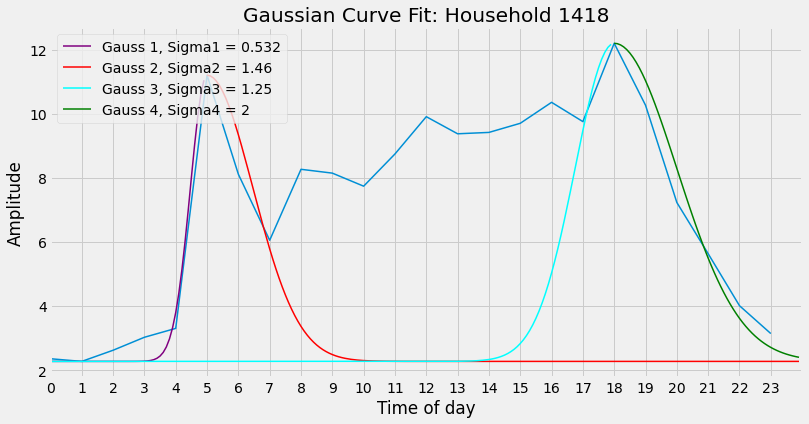

In [405]:
# build the plot
fig, ax = plt.subplots(figsize=(12,6))
plt.style.use('fivethirtyeight')  

# Plot the households loadprofile
fig = plt.plot(describe_household(id = houseID).iloc[0,0:24], linewidth = 1.5)#, linestyle = 'dashed')
plt.title("Household "+str(i))

# Plot Gauss Fit

# ax.plot(x_all[:],y1[:],linewidth = 0.5, linestyle = 'dotted',color = 'purple')
ax.plot(x_all[:10*df['0_x'].values[0]],y1[:10*df['0_x'].values[0]],linewidth = 1.5, color = 'purple',label = "Gauss 1, Sigma1 = " + str('{0:.3g}'.format(sigma1)))
# ax.plot(x_all[:],y2[:],linewidth = 0.5, linestyle = 'dotted',color = 'red')
ax.plot(x_all[10*df['0_x'].values[0]:],y2[10*df['0_x'].values[0]:],linewidth = 1.5,color = 'red', label = "Gauss 2, Sigma2 = " + str('{0:.3g}'.format(sigma2)))
# ax.plot(x_all[:],y3[:],linewidth = 0.5, linestyle = 'dotted',color = 'cyan')
ax.plot(x_all[:10*df['0_y'].values[0]],y3[:10*df['0_y'].values[0]],linewidth = 1.5, color = 'cyan',label = "Gauss 3, Sigma3 = " + str('{0:.3g}'.format(sigma3)))
# ax.plot(x_all[:],y4[:],linewidth = 0.5, linestyle = 'dotted',color = 'green')
ax.plot(x_all[10*df['0_y'].values[0]:],y4[10*df['0_y'].values[0]:],linewidth = 1.5, color = 'green',label = "Gauss 4, Sigma4 = " + str('{0:.3g}'.format(sigma4)))

plt.legend(loc = "upper left")
# Set the labels and axis limits
ax.set_xlim([0,24])
ax.set_xlabel('Time of day')
ax.set_ylabel("Amplitude")
ax.set_title('Gaussian Curve Fit: Household ' + str(houseID))

# # Save the figure
# plt.savefig('GaussCurveFit' + str(houseID) + '.png', dpi=72, bbox_inches='tight')
plt.show()

### Create code that plots the sigma changes

In [102]:
# y2 = gauss(x_all, H_offset,A1,mu1,initialSigma())
# # Household ids
# # id = [2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]

# x_all = np.arange(0, 24, 0.001) # entire range of x, both in and out of spec

# # build the plot
# fig, ax = plt.subplots(figsize=(12,6))
# plt.style.use('fivethirtyeight')  

# # Plot the households loadprofile
# fig = plt.plot(describe_household().iloc[0,0:24])
# plt.title("Household "+str(i))

# # Plot Gaussian fit
# ax.plot(x_all[:len(x_all)//4],y2[:len(y2)//4], linewidth = 0.8)

# for i in np.arange(0,1,0.2):
#     y2 = gauss(x_all, H_offset,A1,mu1,initialSigma()+i)
#     # Plot Gaussian fit
#     ax.plot(x_all[:len(x_all)//4],y2[:len(y2)//4],linewidth = 0.5)

# # Set the labels and axis limits
# ax.set_xlim([0,24])
# ax.set_xlabel('Time of day')
# ax.set_ylabel("Amplitude")
# ax.set_title('Gaussian Curve Fit')

# # # Save the figure
# # plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight')
# plt.show()

In [14]:
# id = [12020322]#[483]#[2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]

#  1005558,  1006685,  1006691, 12029058, 12029066
houseID = 29

df = describe_household(id = houseID)

# Determine the y-offset i.e. minimum value in day
H_offset = df.iloc[0,:24].min()

# Determine the amplitude of gaussian
A1 = df[str(df['0_x'].values[0])].values[0] - H_offset # Adjust for offset
A2 = df[str(df['0_y'].values[0])].values[0] - H_offset

# Determine the mean of the gaussian
mu1 = df['0_x'].values[0]
mu2 = df['0_y'].values[0]

#### New and improved Function that calculates overall error of gauss fit

In [15]:
from sklearn.metrics import mean_squared_error
import math

In [16]:
def Sigma1(increment = 0):
    # Conditional if statement to check that 
    p1 = 4 + increment

    i1 = 0

    Xpeak1 = df[str(df['0_x'].values[0])].values[0]

    for c in df:
        if int(c) != df['0_x'].values[0]:
            x1 = df[str(df['0_x'].values[0] - int(c))].values[0]
            temp1 = Xpeak1 - x1

            if temp1 >= 0.0:
                Xpeak1 = x1
            else:
                i1 = df['0_x'].values[0]-int(c) # i returns the index of the lower boundary of range
                break
        else:
            i1 = df['0_x'].values[0]-int(c) # i returns the index of the lower boundary of range
            break

    range1 = 2*(np.sqrt((df['0_x'].values[0] - i1)**2))
    
    sigma1 = range1/p1

    return sigma1, i1

In [17]:
# Code that finds the value one point above the range index
sigma1, i1 = Sigma1()

# Calculate error
actual = df.iloc[0,i1:df['0_x'].values[0]].to_list()
predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1)
MSE = mean_squared_error(actual, predicted)
RMSE = math.sqrt(MSE)

tolerance1 = RMSE - RMSE*0.95
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
t = 0
while RMSE > tolerance1:
    previous_error1 = RMSE

    sigma1, i1= Sigma1(increment = i)
    predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)   
    # conditional for gauss 1
    if RMSE > previous_error1:
        i = i + 0.1
        sigma1, i1 = Sigma1(increment = i)
        predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE) 
    else:
        i = i - 0.1
        sigma1, i1 = Sigma1(increment = i)
        predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE) 

    t = t + 1
    if t >= 10000:
        t = 0
        i = 0
        tolerance1 = tolerance1 + 0.1

RMSE1 = RMSE
print("RMSE1 = {}".format(RMSE1))
sigma1 = np.sqrt(sigma1**2)

RMSE1 = 0.631596801759027


In [18]:
def Sigma2(increment = 0):
    # Conditional if statement to check that 
    p1 = 4 + increment

    i1 = 0

    Xpeak1 = df[str(df['0_x'].values[0])].values[0]# Get the value at the peak
    
    for c in df:
        x1 = df[str(df['0_x'].values[0]+int(c))].values[0]
        temp1 = Xpeak1 - x1
        # print("temp1 = Xpeak1 - x1 = {} - {} = {}".format(Xpeak1,x1,temp1))
        if temp1 >= 0:
            Xpeak1 = x1
        else:
            i1 = df['0_x'].values[0]+int(c) # i returns the index of the lower boundary of range
            break

    range1 = 2*(np.sqrt((df['0_x'].values[0] - i1)**2))

    sigma1 = range1/p1

    return sigma1, i1


In [19]:
sigma2, i2= Sigma2()

# Calculate error
actual = df.iloc[0,df['0_x'].values[0]:i2].to_list()
predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
MSE = mean_squared_error(actual, predicted)
RMSE = math.sqrt(MSE)

tolerance2 = RMSE - RMSE*0.95
print(tolerance2)
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
t = 0
while RMSE > tolerance2:

    # print("RMSE = {}".format(RMSE))
    # print("tolerance2 = {}".format(tolerance2))
    # print("actual = {}".format(actual))
    # print("predicted = {}".format(predicted))
    previous_error2 = RMSE
    sigma2, i2 = Sigma2(increment = i)
    predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)
    
    # Conditional for gauss2
    if RMSE > previous_error2:
        i = i + 0.1
        sigma2, i2 = Sigma2(increment = i)
        predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)
    else:
        i = i -0.1        
        sigma2, i2 = Sigma2(increment = i)
        predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)

    t = t + 1
    if t >= 1000:
        t = 0
        i = 0
        tolerance2 = tolerance2 + 0.1


RMSE2 = RMSE
print("RMSE2 = {}".format(RMSE2))
sigma2 = np.sqrt(sigma2**2)

0.07024502755061546
RMSE2 = 0.06790923733263239


In [20]:
def Sigma3(increment = 0):  
    # Conditional if statement to check that 
    p2 = 4 + increment

    # i1 = 0
    i2 = 0

    Xpeak2 = df[str(df['0_y'].values[0])].values[0]

    for c in df:
        x2 = df[str(df['0_y'].values[0]-int(c))].values[0]
        temp2 = Xpeak2 - x2
        
        if temp2 >= 0.0:
            Xpeak2 = x2
        else:
            i2 = df['0_y'].values[0]-int(c)+1 # i returns the index of the lower boundary of range
            break

    range2 = 2*(np.sqrt((df['0_y'].values[0] - i2)**2))

    sigma2 = range2/p2

    return sigma2, i2


In [21]:
# df.iloc[0,i3:df['0_y'].values[0]]

NameError: name 'i3' is not defined

In [22]:
# Code that finds the value one point above the range index
sigma3, i3 = Sigma3()

# Calculate error
actual = df.iloc[0,i3:df['0_y'].values[0]].to_list()
predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
MSE = mean_squared_error(actual, predicted)
RMSE = math.sqrt(MSE)

tolerance1 = RMSE - RMSE*0.95
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
t = 0
while RMSE > tolerance1:
    previous_error3 = RMSE
    # print(sigma3)
    # print("RMSE = {}".format(RMSE))

    sigma3, i3 = Sigma3(increment = i)
    predicted = gauss(np.arange(i3,df['0_y'].values[0],1), H_offset, A2, mu2, sigma3)
    # print('actual = {}'.format(actual))
    # print('predicted = {}'.format(predicted))
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    # conditional for gauss 1
    if RMSE > previous_error3:
        i = i + 0.1
        sigma3, i3 = Sigma3(increment = i)
        predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)
    else:
        i = i - 0.1
        sigma3, i3 = Sigma3(increment = i)
        predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)

    t = t + 1
    if t >= 10000:
        t = 0
        i = 0
        tolerance1 = tolerance1 + 0.1
   

RMSE3 = RMSE
print("RMSE3 = {}".format(RMSE))
sigma3 = np.sqrt(sigma3**2)


RMSE3 = 0.33882398305012545


In [23]:
def Sigma4(increment=0):
    # Conditional if statement to check that 
    p2 = 4 + increment

    i2 = 0

    Xpeak2 = df[str(df['0_y'].values[0])].values[0]# Get the value at the peak
    
    for c in df:
        try:
            x2 = df[str(df['0_y'].values[0]+int(c))].values[0] # Get the one after the peak
            temp2 = Xpeak2 - x2
            # print("temp2 = Xpeak2 - x2 = {} - {} = {}".format(Xpeak2,x2,temp2))
            
            if temp2 >= 0:
                Xpeak2 = x2
            else:
                i2 = df['0_y'].values[0]+int(c) # i returns the index of the lower boundary of range
                break
            
        except KeyError:
            i2 = df['0_y'].values[0]+int(c)
            break

    range2 = 2*(np.sqrt((df['0_y'].values[0] - i2)**2))
    
    sigma2 = range2/p2

    return sigma2, i2

In [24]:
sigma4, i4= Sigma4()

actual = df.iloc[0,df['0_y'].values[0]:i4].to_list()
predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
MSE = mean_squared_error(actual, predicted)
RMSE = math.sqrt(MSE)

tolerance2 = RMSE - RMSE*0.95
# print(tolerance2)
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
t = 0
while RMSE > tolerance2:
    previous_error4 = RMSE
    # print('sigma4 = {}'.format(sigma4))
    # print('RMSE = {}'.format(RMSE))
    sigma4, i4 = Sigma4(increment = i)
    predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)
    
    # Conditional for gauss2
    if RMSE > previous_error4:
        i = i + 0.1
        sigma4, i4 = Sigma4(increment = i)
        predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)

    else:
        i = i - 0.1        
        sigma4, i4 = Sigma4(increment = i)
        predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)

    t = t + 1
    if t >= 10000:
        t = 0
        i = 0
        tolerance2 = tolerance2 + 0.1
print(tolerance2)
RMSE4 = RMSE
sigma4 = np.sqrt(sigma4**2)


0.17793755978752848


#### Plot Gaussian Fit

In [25]:
# sigma1, sigma3, i1, i3= initialSigma1()
# sigma2, sigma4, i2, i4 = initialSigma2()
x_all = np.arange(0, 24, 0.1) # entire range of x, both in and out of spec
y1 = gauss(x_all, H_offset,A1,mu1,sigma1)
y2 = gauss(x_all, H_offset,A1,mu1,sigma2)
y3 = gauss(x_all, H_offset,A2,mu2,sigma3)
y4 = gauss(x_all, H_offset,A2,mu2,sigma4)

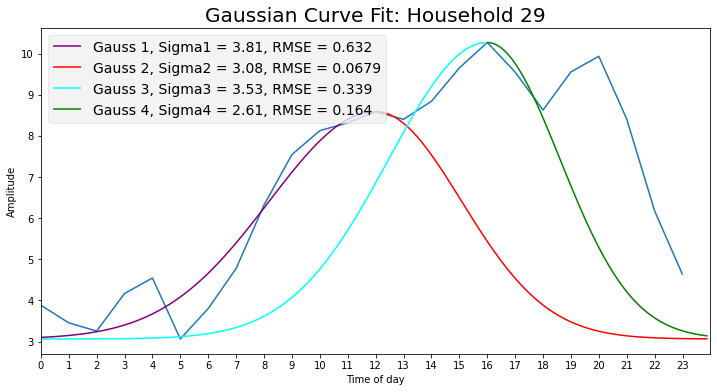

In [26]:
# build the plot
fig, ax = plt.subplots(figsize=(12,6))
plt.style.use('fivethirtyeight')  

# Plot the households loadprofile
fig = plt.plot(describe_household(id = houseID).iloc[0,0:24], linewidth = 1.5)#, linestyle = 'dashed')
plt.title("Household "+str(i))

# Plot Gauss Fit

# ax.plot(x_all[:],y1[:],linewidth = 0.5, linestyle = 'dotted',color = 'purple')
ax.plot(x_all[:10*df['0_x'].values[0]],y1[:10*df['0_x'].values[0]],linewidth = 1.5, color = 'purple',label = "Gauss 1, Sigma1 = " + str('{0:.3g}'.format(sigma1))+ ", RMSE = " + str('{0:.3g}'.format(RMSE1)))
# ax.plot(x_all[:],y2[:],linewidth = 0.5, linestyle = 'dotted',color = 'red')
ax.plot(x_all[10*df['0_x'].values[0]:],y2[10*df['0_x'].values[0]:],linewidth = 1.5,color = 'red', label = "Gauss 2, Sigma2 = " + str('{0:.3g}'.format(sigma2))+ ", RMSE = " + str('{0:.3g}'.format(RMSE2)))
# ax.plot(x_all[:],y3[:],linewidth = 0.5, linestyle = 'dotted',color = 'cyan')
ax.plot(x_all[:10*df['0_y'].values[0]],y3[:10*df['0_y'].values[0]],linewidth = 1.5, color = 'cyan',label = "Gauss 3, Sigma3 = " + str('{0:.3g}'.format(sigma3))+ ", RMSE = " + str('{0:.3g}'.format(RMSE3)))
# ax.plot(x_all[:],y4[:],linewidth = 0.5, linestyle = 'dotted',color = 'green')
ax.plot(x_all[10*df['0_y'].values[0]:],y4[10*df['0_y'].values[0]:],linewidth = 1.5, color = 'green',label = "Gauss 4, Sigma4 = " + str('{0:.3g}'.format(sigma4))+ ", RMSE = " + str('{0:.3g}'.format(RMSE4)))

plt.legend(loc = "upper left")
# Set the labels and axis limits
ax.set_xlim([0,24])
ax.set_xlabel('Time of day')
ax.set_ylabel("Amplitude")
ax.set_title('Gaussian Curve Fit: Household ' + str(houseID))

# # Save the figure
# plt.savefig('GaussCurveFit' + str(houseID) + '.png', dpi=72, bbox_inches='tight')
plt.show()

## Calculate the RMSE of the entire profile

In [27]:
x_1 = np.arange(0, mu1, 1)
x_2 = np.arange(mu1, i2, 1)
x_3 = np.arange(i3, mu2,1)
x_4 = np.arange(mu2, 24,1)

x_vals = np.hstack((x_1,x_2,x_3,x_4))
x_vals_1 = np.unique(x_vals)


#### Create synthetic profile

In [28]:
def straight_line(m,x,b):
    return m*x+b

In [29]:
y1 = gauss(x_1, H_offset,A1,mu1,sigma1)
y2 = gauss(x_2, H_offset,A1,mu1,sigma2)
y3 = gauss(x_3, H_offset,A2,mu2,sigma3)
y4 = gauss(x_4, H_offset,A2,mu2,sigma4)

if len(x_vals_1) == 24:
    print("Entire array is captured")
    if x_2[-1] == x_3[0]:
        print('repeating value')
        x_3 = x_3[1:] # Remove the first value of the x-array
        y3 = gauss(x_3, H_offset,A2,mu2,sigma3) # Re-calculate the y-values for gauss 3
        synth = np.hstack((y1,y2,y3,y4)) # Generate the synthetic values
    else:
        synth = np.hstack((y1,y2,y3,y4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values

else:
    print("Missing hours need to be saved")
    x_5 = np.arange(i2,i3,1)
    x_vals_1 = np.hstack((x_1,x_2,x_5,x_3,x_4))
    x_vals_1 = np.unique(x_vals_1)

    # Synthesize the mid range behaviour
    m = (gauss(x_3[0], H_offset,A2,mu2,sigma3) - gauss(x_2[-1], H_offset,A1,mu1,sigma2))/(x_3[0]-x_2[-1]) # Calculate slope
    b = gauss(x_3[0], H_offset,A2,mu2,sigma3) - m*x_3[0] # Calculate b constant for straight line equation
    y_mid = straight_line(m,x_5,b)

    synth = np.hstack((y1,y2,y_mid,y3,y4))

Entire array is captured
repeating value


### Calculate the RMSE of the actual vs synthetic profile

In [30]:
actual = df.iloc[0,0:24]
predicted = synth
MSE = mean_squared_error(actual, predicted)
RMSE = math.sqrt(MSE)

### Plot the synth and actual profile

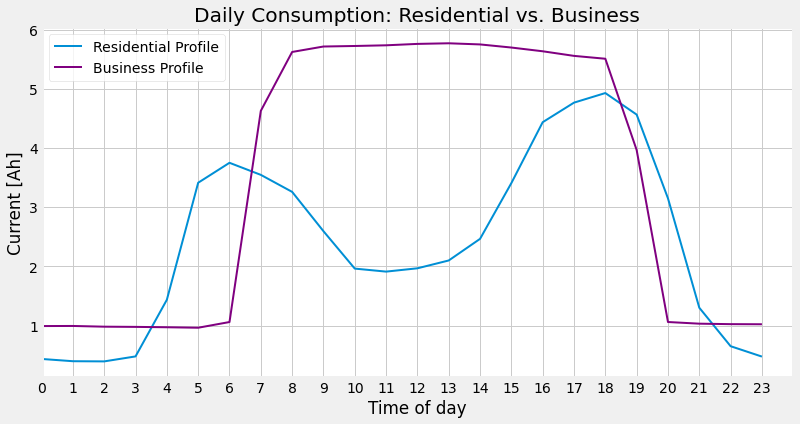

In [55]:
# houseID = 920# Business
houseID = 2230
# build the plot
fig, ax = plt.subplots(figsize=(12,6))
plt.style.use('fivethirtyeight')  

# Plot the households loadprofile
fig = plt.plot(describe_household(id = 2230).iloc[0,0:24]*0.45, linewidth = 2, label = "Residential Profile")#, linestyle = 'dashed')
plt.title("Daily Consumption: Residential vs. Business")

ax.plot(describe_household(id = 920).iloc[0,0:24]*1.4, linewidth = 2, label = "Business Profile", color = 'purple')
# ax = plt.axes()
ax.set_facecolor("white")
x_all = np.arange(0,24,1)
# Plot Gauss Fit
# ax.plot(x_all,synth,linewidth = 1.5, color = 'purple',label = "Synthetic Profile, RMSE = " + str('{0:.3g}'.format(RMSE)))
# plt.figure(facecolor='white')

plt.legend(loc = "upper left", facecolor = "white")
# Set the labels and axis limits
ax.set_xlim([0,24])
ax.set_xlabel('Time of day')
ax.set_ylabel("Current [Ah]")
# ax.set_title('Meter Number: ' + str(houseID))

# # Save the figure
plt.savefig('Business_vs_residential.png', dpi=72, bbox_inches='tight',facecolor='white', edgecolor='none')
plt.show()

#  Write code to calculate the RMSE of all households and plot a histogram of the RMSE

In [970]:
print(len(Xbin['1200-2500']))

319


In [909]:
for id in Xbin:
    print("ids = {}".format(id))

ids = 0-1
ids = 1-50
ids = 50-150
ids = 150-400
ids = 400-600
ids = 600-1200
ids = 1200-2500
ids = 2500-4000


In [61]:
# Create dataframe to store RMSE
list_ids = []
for id in Xbin['600-1200']:
    list_ids.append(id)

ids_df = pd.DataFrame(index = list_ids, columns = ['RMSE'])

for id in tqdm(Xbin['600-1200']):
    houseID = id
    df = describe_household(id = houseID)

    # Determine the y-offset i.e. minimum value in day
    H_offset = df.iloc[0,:24].min()

    # Determine the amplitude of gaussian
    A1 = df[str(df['0_x'].values[0])].values[0] - H_offset # Adjust for offset
    A2 = df[str(df['0_y'].values[0])].values[0] - H_offset

    # Determine the mean of the gaussian
    mu1 = df['0_x'].values[0]
    mu2 = df['0_y'].values[0]
    # **********************************************************************************************************************************************
    # Fit the first gaussian
    sigma1, i1 = Sigma1()

    # Calculate error
    actual = df.iloc[0,i1:df['0_x'].values[0]].to_list()
    predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    tolerance1 = RMSE - RMSE*0.95
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance1:
        previous_error1 = RMSE

        sigma1, i1= Sigma1(increment = i)
        predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)   
        # conditional for gauss 1
        if RMSE > previous_error1:
            i = i + 0.1
            sigma1, i1 = Sigma1(increment = i)
            predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE) 
        else:
            i = i - 0.1
            sigma1, i1 = Sigma1(increment = i)
            predicted = gauss(np.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE) 

        t = t + 1
        if t >= 10000:
            t = 0
            i = 0
            tolerance1 = tolerance1 + 0.1

    RMSE1 = RMSE
    # print("RMSE1 = {}".format(RMSE1))
    sigma1 = np.sqrt(sigma1**2)
    # **********************************************************************************************************************************************
    # Fit the secnd gaussian
    sigma2, i2= Sigma2()

    # Calculate error
    actual = df.iloc[0,df['0_x'].values[0]:i2].to_list()
    predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    tolerance2 = RMSE - RMSE*0.95
    # print(tolerance2)
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance2:

        # print("RMSE = {}".format(RMSE))
        # print("tolerance2 = {}".format(tolerance2))
        # print("actual = {}".format(actual))
        # print("predicted = {}".format(predicted))
        previous_error2 = RMSE
        sigma2, i2 = Sigma2(increment = i)
        predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)
        
        # Conditional for gauss2
        if RMSE > previous_error2:
            i = i + 0.1
            sigma2, i2 = Sigma2(increment = i)
            predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)
        else:
            i = i -0.1        
            sigma2, i2 = Sigma2(increment = i)
            predicted = gauss(np.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)

        t = t + 1
        if t >= 1000:
            t = 0
            i = 0
            tolerance2 = tolerance2 + 0.1


    RMSE2 = RMSE
    # print("RMSE2 = {}".format(RMSE2))
    sigma2 = np.sqrt(sigma2**2)
    # **********************************************************************************************************************************************
    # Fit the third gaussian
    # Code that finds the value one point above the range index
    sigma3, i3 = Sigma3()

    # Calculate error
    actual = df.iloc[0,i3:df['0_y'].values[0]].to_list()
    predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    tolerance1 = RMSE - RMSE*0.95
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance1:
        previous_error3 = RMSE
        # print(sigma3)
        # print("RMSE = {}".format(RMSE))

        sigma3, i3 = Sigma3(increment = i)
        predicted = gauss(np.arange(i3,df['0_y'].values[0],1), H_offset, A2, mu2, sigma3)
        # print('actual = {}'.format(actual))
        # print('predicted = {}'.format(predicted))
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)

        # conditional for gauss 1
        if RMSE > previous_error3:
            i = i + 0.1
            sigma3, i3 = Sigma3(increment = i)
            predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)
        else:
            i = i - 0.1
            sigma3, i3 = Sigma3(increment = i)
            predicted = gauss(np.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)

        t = t + 1
        if t >= 10000:
            t = 0
            i = 0
            tolerance1 = tolerance1 + 0.1
    

    RMSE3 = RMSE
    # print("RMSE3 = {}".format(RMSE))
    sigma3 = np.sqrt(sigma3**2)
    # **********************************************************************************************************************************************
    # Fit the 4th gaussian
    sigma4, i4= Sigma4()

    actual = df.iloc[0,df['0_y'].values[0]:i4].to_list()
    predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)

    tolerance2 = RMSE - RMSE*0.95
    # print(tolerance2)
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance2:
        previous_error4 = RMSE
        # print('sigma4 = {}'.format(sigma4))
        # print('RMSE = {}'.format(RMSE))
        sigma4, i4 = Sigma4(increment = i)
        predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
        MSE = mean_squared_error(actual, predicted)
        RMSE = math.sqrt(MSE)
        
        # Conditional for gauss2
        if RMSE > previous_error4:
            i = i + 0.1
            sigma4, i4 = Sigma4(increment = i)
            predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)

        else:
            i = i - 0.1        
            sigma4, i4 = Sigma4(increment = i)
            predicted = gauss(np.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
            MSE = mean_squared_error(actual, predicted)
            RMSE = math.sqrt(MSE)

        t = t + 1
        if t >= 10000:
            t = 0
            i = 0
            tolerance2 = tolerance2 + 0.1
    # print(tolerance2)
    RMSE4 = RMSE
    sigma4 = np.sqrt(sigma4**2)
    # **********************************************************************************************************************************************
    # Determine the complete synthetic profile
    x_1 = np.arange(0, mu1, 1)
    x_2 = np.arange(mu1, i2, 1)
    x_3 = np.arange(i3, mu2,1)
    x_4 = np.arange(mu2, 24,1)

    x_vals = np.hstack((x_1,x_2,x_3,x_4))
    x_vals_1 = np.unique(x_vals)

    y1 = gauss(x_1, H_offset,A1,mu1,sigma1)
    y2 = gauss(x_2, H_offset,A1,mu1,sigma2)
    y3 = gauss(x_3, H_offset,A2,mu2,sigma3)
    y4 = gauss(x_4, H_offset,A2,mu2,sigma4)

    if len(x_vals_1) == 24:
        # print("Entire array is captured")
        if x_2[-1] == x_3[0]:
            # print('repeating value')
            x_3 = x_3[1:] # Remove the first value of the x-array
            y3 = gauss(x_3, H_offset,A2,mu2,sigma3) # Re-calculate the y-values for gauss 3
            synth = np.hstack((y1,y2,y3,y4)) # Generate the synthetic values
        else:
            synth = np.hstack((y1,y2,y3,y4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values

    else:
        # print("Missing hours need to be saved")
        x_5 = np.arange(i2,i3,1)
        x_vals_1 = np.hstack((x_1,x_2,x_5,x_3,x_4))
        x_vals_1 = np.unique(x_vals_1)

        # Synthesize the mid range behaviour
        m = (gauss(x_3[0], H_offset,A2,mu2,sigma3) - gauss(x_2[-1], H_offset,A1,mu1,sigma2))/(x_3[0]-x_2[-1]) # Calculate slope
        b = gauss(x_3[0], H_offset,A2,mu2,sigma3) - m*x_3[0] # Calculate b constant for straight line equation
        y_mid = straight_line(m,x_5,b)

        synth = np.hstack((y1,y2,y_mid,y3,y4))
    # **********************************************************************************************************************************************
    # Calculate the synthetic profiles RMSE
    actual = df.iloc[0,0:24]
    predicted = synth
    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)
    # **********************************************************************************************************************************************
    # Store the RMSE error
    ids_df.loc[id] = RMSE
    # **********************************************************************************************************************************************
    # **********************************************************************************************************************************************
    # **********************************************************************************************************************************************
    # **********************************************************************************************************************************************


<ipython-input-61-feefff81c114>:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/1500 [00:00<?, ?it/s]

In [57]:
houseID

186

In [58]:
df

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,0_x,0_y
0,9.187829,8.066416,7.47914,7.227527,7.319854,7.34624,8.866,9.186962,10.091768,10.966717,...,8.697976,12.967574,14.589599,16.168695,16.056045,15.153806,12.866735,10.815511,9,13


In [934]:
df_ids_600_1200 = ids_df.copy()

In [947]:
df_ids_600_1200['RMSE'].unique()

array([1.5869524328596147, nan], dtype=object)

### Running Synthetic Profile fit code using Cupy and numba

In [44]:
import cupy as cp
from numba import jit
from sklearn.metrics import mean_squared_error

In [47]:
# Create dataframe to store RMSE
list_ids = []
for id in Xbin['1200-2500']:
    list_ids.append(id)

ids_df = pd.DataFrame(index = list_ids, columns = ['RMSE'])

for id in tqdm(Xbin['1200-2500']):
    houseID = id
    df = describe_household(id = houseID)

    # Determine the y-offset i.e. minimum value in day
    H_offset = df.iloc[0,:24].min()

    # Determine the amplitude of gaussian
    A1 = df[str(df['0_x'].values[0])].values[0] - H_offset # Adjust for offset
    A2 = df[str(df['0_y'].values[0])].values[0] - H_offset

    # Determine the mean of the gaussian
    mu1 = df['0_x'].values[0]
    mu2 = df['0_y'].values[0]
    # **********************************************************************************************************************************************
    # Fit the first gaussian
    sigma1, i1 = Sigma1()

    # Calculate error
    actual = df.iloc[0,i1:df['0_x'].values[0]].to_list()
    predicted = gauss(cp.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1)
    MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
    RMSE = cp.sqrt(MSE)

    tolerance1 = RMSE - RMSE*0.95
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance1:
        previous_error1 = RMSE

        sigma1, i1= Sigma1(increment = i)
        predicted = gauss(cp.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
        MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
        RMSE = cp.sqrt(MSE)   
        # conditional for gauss 1
        if RMSE > previous_error1:
            i = i + 0.1
            sigma1, i1 = Sigma1(increment = i)
            predicted = gauss(cp.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
            MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
            RMSE = cp.sqrt(MSE) 
        else:
            i = i - 0.1
            sigma1, i1 = Sigma1(increment = i)
            predicted = gauss(cp.arange(i1,df['0_x'].values[0],1),H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
            MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
            RMSE = cp.sqrt(MSE) 

        t = t + 1
        if t >= 10000:
            t = 0
            i = 0
            tolerance1 = tolerance1 + 0.1

    RMSE1 = RMSE
    # print("RMSE1 = {}".format(RMSE1))
    sigma1 = cp.sqrt(sigma1**2)
    # **********************************************************************************************************************************************
    # Fit the secnd gaussian
    sigma2, i2= Sigma2()

    # Calculate error
    actual = df.iloc[0,df['0_x'].values[0]:i2].to_list()
    predicted = gauss(cp.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
    MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
    RMSE = cp.sqrt(MSE)

    tolerance2 = RMSE - RMSE*0.95
    # print(tolerance2)
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance2:

        # print("RMSE = {}".format(RMSE))
        # print("tolerance2 = {}".format(tolerance2))
        # print("actual = {}".format(actual))
        # print("predicted = {}".format(predicted))
        previous_error2 = RMSE
        sigma2, i2 = Sigma2(increment = i)
        predicted = gauss(cp.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
        MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
        RMSE = cp.sqrt(MSE)
        
        # Conditional for gauss2
        if RMSE > previous_error2:
            i = i + 0.1
            sigma2, i2 = Sigma2(increment = i)
            predicted = gauss(cp.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
            MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
            RMSE = cp.sqrt(MSE)
        else:
            i = i -0.1        
            sigma2, i2 = Sigma2(increment = i)
            predicted = gauss(cp.arange(df['0_x'].values[0],i2,1),H_offset,A1,mu1,sigma2)
            MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
            RMSE = cp.sqrt(MSE)

        t = t + 1
        if t >= 1000:
            t = 0
            i = 0
            tolerance2 = tolerance2 + 0.1


    RMSE2 = RMSE
    # print("RMSE2 = {}".format(RMSE2))
    sigma2 = cp.sqrt(sigma2**2)
    # **********************************************************************************************************************************************
    # Fit the third gaussian
    # Code that finds the value one point above the range index
    sigma3, i3 = Sigma3()

    # Calculate error
    actual = df.iloc[0,i3:df['0_y'].values[0]].to_list()
    predicted = gauss(cp.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
    MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
    RMSE = cp.sqrt(MSE)

    tolerance1 = RMSE - RMSE*0.95
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance1:
        previous_error3 = RMSE
        # print(sigma3)
        # print("RMSE = {}".format(RMSE))

        sigma3, i3 = Sigma3(increment = i)
        predicted = gauss(cp.arange(i3,df['0_y'].values[0],1), H_offset, A2, mu2, sigma3)
        # print('actual = {}'.format(actual))
        # print('predicted = {}'.format(predicted))
        MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
        RMSE = cp.sqrt(MSE)

        # conditional for gauss 1
        if RMSE > previous_error3:
            i = i + 0.1
            sigma3, i3 = Sigma3(increment = i)
            predicted = gauss(cp.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
            MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
            RMSE = cp.sqrt(MSE)
        else:
            i = i - 0.1
            sigma3, i3 = Sigma3(increment = i)
            predicted = gauss(cp.arange(i3,df['0_y'].values[0],1),H_offset,A2,mu2,sigma3)
            MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
            RMSE = cp.sqrt(MSE)

        t = t + 1
        if t >= 10000:
            t = 0
            i = 0
            tolerance1 = tolerance1 + 0.1
    

    RMSE3 = RMSE
    # print("RMSE3 = {}".format(RMSE))
    sigma3 = cp.sqrt(sigma3**2)
    # **********************************************************************************************************************************************
    # Fit the 4th gaussian
    sigma4, i4= Sigma4()

    actual = df.iloc[0,df['0_y'].values[0]:i4].to_list()
    predicted = gauss(cp.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
    MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
    RMSE = cp.sqrt(MSE)

    tolerance2 = RMSE - RMSE*0.95
    # print(tolerance2)
    i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function
    t = 0
    while RMSE > tolerance2:
        previous_error4 = RMSE
        # print('sigma4 = {}'.format(sigma4))
        # print('RMSE = {}'.format(RMSE))
        sigma4, i4 = Sigma4(increment = i)
        predicted = gauss(cp.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
        MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
        RMSE = cp.sqrt(MSE)
        
        # Conditional for gauss2
        if RMSE > previous_error4:
            i = i + 0.1
            sigma4, i4 = Sigma4(increment = i)
            predicted = gauss(cp.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
            MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
            RMSE = cp.sqrt(MSE)

        else:
            i = i - 0.1        
            sigma4, i4 = Sigma4(increment = i)
            predicted = gauss(cp.arange(df['0_y'].values[0],i4,1),H_offset,A2,mu2,sigma4)
            MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
            RMSE = cp.sqrt(MSE)

        t = t + 1
        if t >= 10000:
            t = 0
            i = 0
            tolerance2 = tolerance2 + 0.1
    # print(tolerance2)
    RMSE4 = RMSE
    sigma4 = cp.sqrt(sigma4**2)
    # **********************************************************************************************************************************************
    # Determine the complete synthetic profile
    x_1 = cp.arange(0, mu1, 1)
    x_2 = cp.arange(mu1, i2, 1)
    x_3 = cp.arange(i3, mu2,1)
    x_4 = cp.arange(mu2, 24,1)

    x_vals = cp.hstack((x_1,x_2,x_3,x_4))
    x_vals_1 = cp.unique(x_vals)

    y1 = gauss(x_1, H_offset,A1,mu1,sigma1)
    y2 = gauss(x_2, H_offset,A1,mu1,sigma2)
    y3 = gauss(x_3, H_offset,A2,mu2,sigma3)
    y4 = gauss(x_4, H_offset,A2,mu2,sigma4)

    if len(x_vals_1) == 24:
        # print("Entire array is captured")
        if x_2[-1] == x_3[0]:
            # print('repeating value')
            x_3 = x_3[1:] # Remove the first value of the x-array
            y3 = gauss(x_3, H_offset,A2,mu2,sigma3) # Re-calculate the y-values for gauss 3
            synth = cp.hstack((y1,y2,y3,y4)) # Generate the synthetic values
        else:
            synth = cp.hstack((y1,y2,y3,y4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values

    else:
        # print("Missing hours need to be saved")
        x_5 = cp.arange(i2,i3,1)
        x_vals_1 = cp.hstack((x_1,x_2,x_5,x_3,x_4))
        x_vals_1 = cp.unique(x_vals_1)

        # Synthesize the mid range behaviour
        m = (gauss(x_3[0], H_offset,A2,mu2,sigma3) - gauss(x_2[-1], H_offset,A1,mu1,sigma2))/(x_3[0]-x_2[-1]) # Calculate slope
        b = gauss(x_3[0], H_offset,A2,mu2,sigma3) - m*x_3[0] # Calculate b constant for straight line equation
        y_mid = straight_line(m,x_5,b)

        synth = cp.hstack((y1,y2,y_mid,y3,y4))
    # **********************************************************************************************************************************************
    # Calculate the synthetic profiles RMSE
    actual = df.iloc[0,0:24]
    predicted = synth
    MSE = mean_squared_error(cp.asarray(actual).get(), cp.asarray(predicted).get())
    RMSE = cp.sqrt(MSE)
    # **********************************************************************************************************************************************
    # Store the RMSE error
    ids_df.loc[id] = RMSE
    # **********************************************************************************************************************************************
    # **********************************************************************************************************************************************
    # **********************************************************************************************************************************************
    # **********************************************************************************************************************************************

<ipython-input-47-23c71a923985>:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/319 [00:00<?, ?it/s]

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.